In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

Populating the interactive namespace from numpy and matplotlib


In [2]:
def model(shape):
  model = Sequential()
  model.add(LSTM(units = 200, return_sequences=True, input_shape=(shape)))
  model.add(Dropout(0.3))
  model.add(LSTM(150, return_sequences=True))
  model.add(Dropout(0.25))
  model.add(LSTM(150, return_sequences=True))
  model.add(Dropout(0.25))
  model.add(LSTM(200))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mean_squared_logarithmic_error'])
  
  return model

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

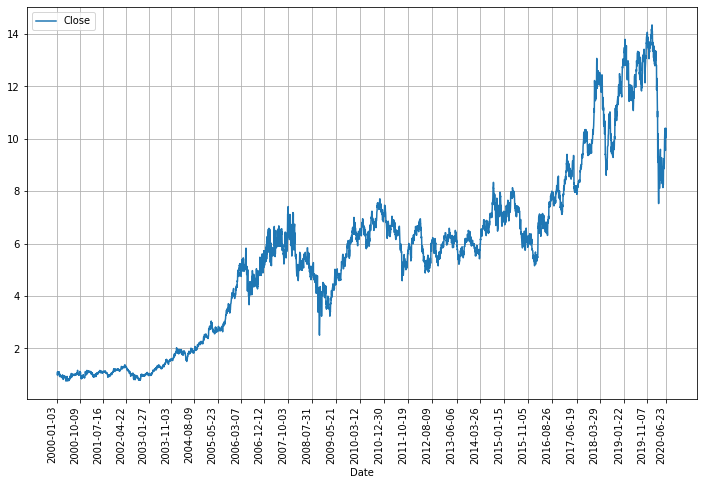

In [3]:
dados = "/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Prevendo_valor_acoes/itausa.csv"
dados = pd.read_csv(dados)

dados['Date'] = pd.to_datetime(dados['Date'])

dados_nulos = dados[dados['Close'].isnull() == True].index
for i in dados_nulos:
  ope = ((dados['Open'].iloc[i-1] + dados['Open'].iloc[i-1]) / 2)	
  high = ((dados['High'].iloc[i-1] + dados['High'].iloc[i-1]) / 2)	
  low = ((dados['Low'].iloc[i-1] + dados['Low'].iloc[i-1]) / 2)	
  close = ((dados['Close'].iloc[i-1] + dados['Close'].iloc[i-1]) / 2)
  aclose = ((dados['Adj Close'].iloc[i-1] + dados['Adj Close'].iloc[i-1]) / 2)	
  volume = ((dados['Volume'].iloc[i-1] + dados['Volume'].iloc[i-1]) / 2)
  
  dados['Open'].iloc[i] = ope
  dados['High'].iloc[i] = high
  dados['Low'].iloc[i] = low
  dados['Close'].iloc[i] = close
  dados['Adj Close'].iloc[i] = aclose
  dados['Volume'].iloc[i] = volume

dados.drop(['High', 'Low', 'Open', 'Adj Close'], axis = 1, inplace=True)

listofNum = list(filter(lambda i: i%200==0, [a for a in range(dados.shape[0])]))
x = dados['Date'].iloc[listofNum]
x = x.append(dados['Date'].tail(1))
x = np.array(x)

dados.plot(x='Date', y='Close', figsize=(12,8))   
plt.xticks(x, rotation='vertical')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [4]:
date = dados['Date']
x_val = dados[['Close']].values
normalizer = MinMaxScaler(feature_range=(0,1))
x_scaled = normalizer.fit_transform(x_val)
data = pd.DataFrame(x_scaled)
data = pd.concat([date, data], axis=1)
data.columns = ['Date', 'Close']
data.head()

,Date,Close
0,2000-01-03,0.024038
1,2000-01-04,0.016426
2,2000-01-05,0.022436
3,2000-01-06,0.023637
4,2000-01-07,0.023237


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


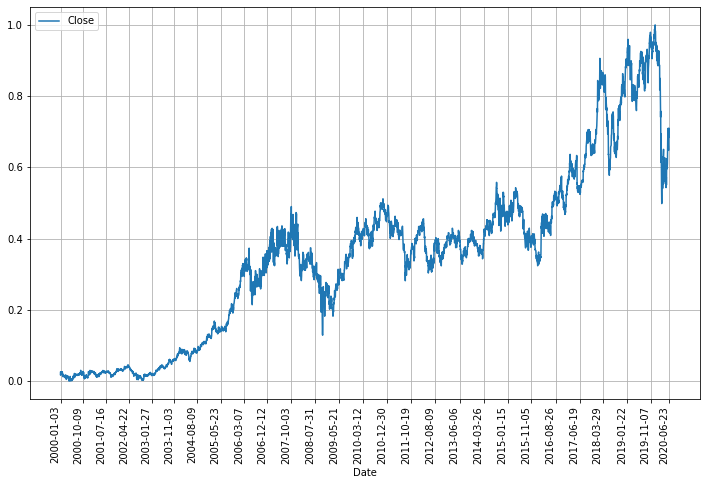

In [5]:
data.plot(x='Date', y='Close', figsize=(12,8))   
plt.xticks(x, rotation='vertical')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [6]:
train = data[dados['Date'] < '2018-03-29'].copy()
valid = data[dados['Date'] >= '2018-03-29'].copy()
train.shape, valid.shape

((4600, 2), (552, 2))

In [7]:
train.head()

,Date,Close
0,2000-01-03,0.024038
1,2000-01-04,0.016426
2,2000-01-05,0.022436
3,2000-01-06,0.023637
4,2000-01-07,0.023237


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


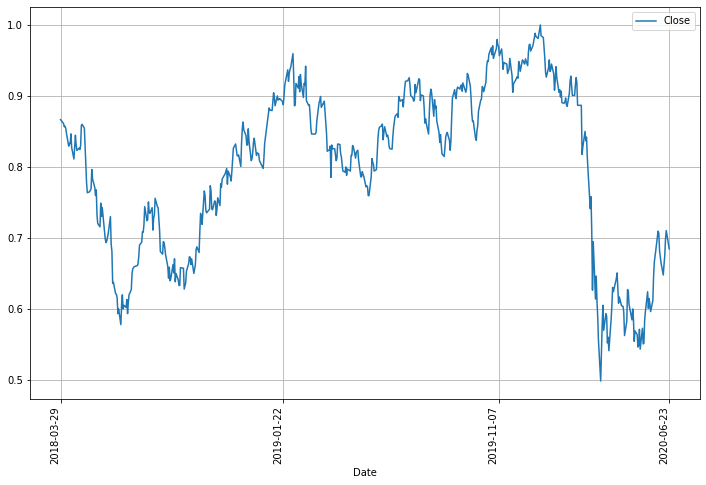

In [8]:
listofNum = list(filter(lambda i: i%200==0, [a for a in range(valid.shape[0])]))
x = valid['Date'].iloc[listofNum]
x = x.append(valid['Date'].tail(1))
x = np.array(x)

valid.plot(x='Date', y='Close', figsize=(12,8))   
plt.xticks(x, rotation='vertical')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [9]:
predict = []
real = []
for i in range(200, train.shape[0]):
  predict.append(train['Close'].iloc[i-200:i])
  real.append(train['Close'].iloc[i])

predict, real = np.array(predict), np.array(real)
predict = np.reshape(predict, (predict.shape[0], predict.shape[1], 1))

In [10]:
model = model((predict.shape[1], 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 200)          161600    
_________________________________________________________________
dropout (Dropout)            (None, 200, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 150)          210600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 150)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 150)          180600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 150)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               2

In [11]:
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Prevendo_valor_acoes/modelo_final.best.hdf5', save_best_only=True, verbose=1)

In [12]:
epochs = 300
batch_size = 16

In [13]:
history = model.fit(predict,
                    real,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint])

Epoch 1/300
275/275 [==============================] - 60s 219ms/step - loss: 0.0108 - mean_squared_logarithmic_error: 0.0055
Epoch 2/300
275/275 [==============================] - 58s 211ms/step - loss: 0.0028 - mean_squared_logarithmic_error: 0.0015
Epoch 3/300
275/275 [==============================] - 58s 211ms/step - loss: 0.0021 - mean_squared_logarithmic_error: 0.0011
Epoch 4/300
275/275 [==============================] - 58s 210ms/step - loss: 0.0019 - mean_squared_logarithmic_error: 9.5547e-04
Epoch 5/300
275/275 [==============================] - 58s 210ms/step - loss: 0.0015 - mean_squared_logarithmic_error: 8.0451e-04
Epoch 6/300
275/275 [==============================] - 58s 210ms/step - loss: 0.0014 - mean_squared_logarithmic_error: 7.4547e-04
Epoch 7/300
275/275 [==============================] - 58s 210ms/step - loss: 0.0014 - mean_squared_logarithmic_error: 7.1412e-04
Epoch 8/300
275/275 [==============================] - 58s 210ms/step - loss: 0.0012 - mean_squared_lo

In [25]:
model.save('/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Prevendo_valor_acoes/pesos_final_epochs_' +str(epochs)+'_batch_'+str(batch_size)+'.h5')

model_json = model.to_json()

with open('/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Prevendo_valor_acoes/modelo_epochs_' +str(epochs)+'_batch_'+str(batch_size)+'.json', 'w') as json_file:
  json_file.write(model_json)

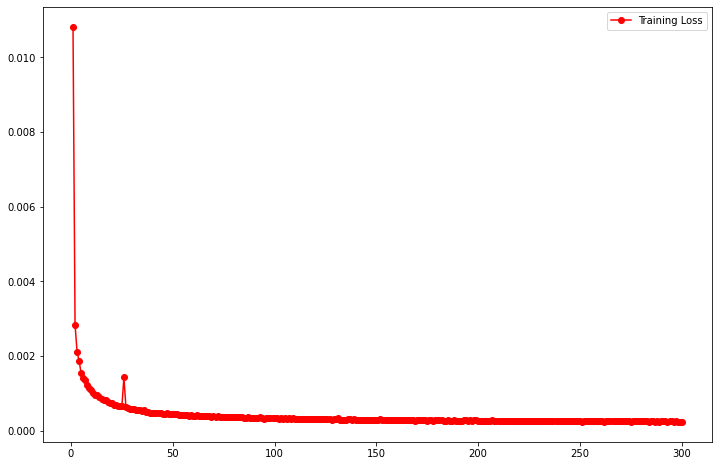

In [17]:
# Making the plot larger
plt.figure(figsize=(12, 8))
#epochs = 50

loss = history.history['loss']                          # Loss on the training data
#val_loss = history.history['val_loss']                  # Loss on the validation data
epochsloss = range(1, len(loss)+1)
#epochsval_loss = [x*freq+1 for x in range(0, len(val_loss))]
#epochsval_loss = range(1, len(val_loss)+1)

plt.plot(epochsloss, loss, 'ro-', label='Training Loss')
#plt.plot(epochsval_loss, val_loss, 'go-', label = 'Validation Loss')
plt.legend()
#plt.savefig(pasta_salvar+'lossmodelo.png')

In [18]:
real_price_valid = valid['Close'].values
cbase = normalizer.transform(dados[['Close']].values)
cbase = cbase.reshape(-1, 5152)[0]
print(cbase.shape)

(5152,)


In [19]:
ipt = cbase[len(cbase) - len(valid) - 200:]
ipt = ipt.reshape(-1, 1)
ipt.shape

(752, 1)

In [20]:
X_valid = []
for i in range(200, ipt.shape[0]):
  X_valid.append(ipt[i-200:i, 0])

X_valid = np.array(X_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [21]:
predict = model.predict(X_valid)

In [22]:
predict_f = normalizer.inverse_transform(predict)
valid_f = normalizer.inverse_transform(valid['Close'].values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


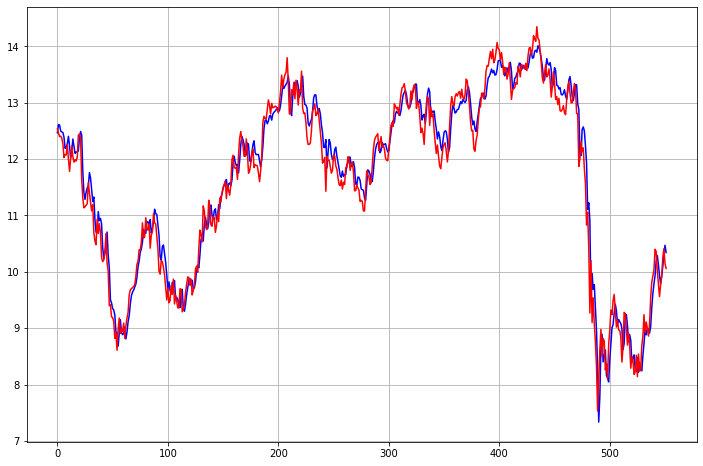

In [23]:
plt.figure(figsize=(12,8))
plt.plot(predict_f, color='blue')
plt.plot(valid_f, color='red')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [24]:
print("Erro:",round(np.sqrt(mean_squared_log_error(valid_f, predict_f))*100, 4),"%")

Erro: 2.4825 %
